In [4]:
import numpy as np
import pandas as pd

In [11]:
with open('C:/Users/user/Desktop/data/X_train') as f:
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)

with open('C:/Users/user/Desktop/data/Y_train') as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype = float)
    
with open('C:/Users/user/Desktop/data/X_test') as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype = float)
    
X_train, Y_train

(array([[33.,  1.,  0., ..., 52.,  0.,  1.],
        [63.,  1.,  0., ..., 52.,  0.,  1.],
        [71.,  0.,  0., ...,  0.,  0.,  1.],
        ...,
        [16.,  0.,  0., ...,  8.,  1.,  0.],
        [48.,  1.,  0., ..., 52.,  0.,  1.],
        [48.,  0.,  0., ...,  0.,  0.,  1.]]),
 array([1., 0., 0., ..., 0., 0., 0.]))

In [12]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(54256, 510)
(54256,)
(27622, 510)


In [14]:
def _normalize(X, train = True, specified_column = None, X_mean = None, X_std = None):
    # This function normalizes specific columns of X.
    # The mean and standard variance of training data will be reused when processing testing data.
    #
    # Arguments:
    #     X: data to be processed
    #     train: 'True' when processing training data, 'False' for testing data
    #     specific_column: indexes of the columns that will be normalized. If 'None', all columns
    #         will be normalized.
    #     X_mean: mean value of training data, used when train = 'False'
    #     X_std: standard deviation of training data, used when train = 'False'
    # Outputs:
    #     X: normalized data
    #     X_mean: computed mean value of training data
    #     X_std: computed standard deviation of training data

    if specified_column == None:
        specified_column = np.arange(X.shape[1])
    if train:
        X_mean = np.mean(X[:, specified_column] ,0).reshape(1, -1)
        X_std  = np.std(X[:, specified_column], 0).reshape(1, -1)

    X[:,specified_column] = (X[:, specified_column] - X_mean) / (X_std + 1e-8)
     
    return X, X_mean, X_std

def _train_test_split(X, Y, ratio = 0.25):
    # This function spilts data into training set and test set.
    train_size = int(len(X) * (1 - ratio))
    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

# Normalize training and testing data
X_train, X_mean, X_std = _normalize(X_train, train = True)
X_test, _, _= _normalize(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)
    
# Split data into training set and validation set

X_train, Y_train, X_val, Y_val = _train_test_split(X_train, Y_train, ratio = 0.2)

print('Size of X_train: {}'.format(X_train.shape))
print('Size of Y_train: {}'.format(Y_train.shape))
print('Size of X_val: {}'.format(X_val.shape))
print('Size of Y_val: {}'.format(Y_val.shape))



Size of X_train: (30383, 510)
Size of Y_train: (30383,)
Size of X_val: (7596, 510)
Size of Y_val: (7596,)


# tool function

### sigmoid function
 - sigmoid function can be used to calculate probability
 
$\sigma(z) = \frac{1}{1+exp(-z)}$ 

In [22]:
def _sigmoid(z):
    # np.clip 將數字限定在區間(min,max)內
    return np.clip(1/(1+np.exp(-z)),1e-8,1-1e-8) 

### logistic regression function
$f_{w,b}(x) = \sigma(\Sigma(X_i \cdot W_i +b))$ 

In [23]:
def _f(X,w,b):
    #　輸出:
    #    羅吉斯回歸後的機率
    #np.matmul = @
    return _sigmoid(np.matmul(X,w)+b)

In [24]:
def _accuracy(predict, label):
    return 1-np.mean(np.abs(predict - label))

# function about Gradient and Loss

### Loss
<p>cross entropy 作為損失函數，$-\Sigma_i(y_i\cdot log(\hat{y}_i)+(1-y_i) \cdot log(1-\hat{y}_i))$ 其中$y_i$是實際標籤，$\hat{y}_i$代表模預測</p>
<p>若模型是多分類，則cross entropy簡化成$-\Sigma_i(y_i \cdot log(\hat{y}_i))$</p>
<p>概似函數lnf(x)對w取偏微分</p>
$\frac{\partial lnL(w,b)}{\partial wi} = -\sum_{n}((y_i^{n}-f_{w,b}(x^n))x_i^n)$<br><br>
梯度下降公式: <br><br>
$w_i \leftarrow w_i - \eta \sum_n(-(y_i^{n}-f_{w,b}(x^n))x_i^n)$ 

In [25]:
def _cross_entropy_loss(y_pred, Y_label):
    cross_entropy = -np.dot(Y_label, np.log(y_pred)) - np.dot((1 - Y_label), np.log(1 - y_pred))
    return cross_entropy

In [26]:
def _gradient(X, Y_label, w,b):
    y_pred = _f(X, w, b)
    pred_error = Y_label-y_pred
    w_grad = -np.sum(pred_error * X.T, 1)
    b_grad = -np.sum(pred_error)
    return w_grad, b_grad

In [80]:
# initialization for weight and bias

w = np.zeros(X_train.shape[1],)
b = np.zeros(1,)
max_itr = 10
batch_size = 10
learning_rate = 0.1

train_loss =[]
valid_loss = []
train_acc = []
valid_acc = []
step = 1

for epoch in range(max_itr):
    randomize = np.arange(X_train.shape[0])
    np.random.shuffle(randomize)
    
    X_train = X_train[randomize]
    Y_train = Y_train[randomize]
    #print('epoch {}:'.format(epoch))
    
    # mini-batch training
    for idx in range(int(X_train.shape[0] / batch_size)):
        X = X_train[idx*batch_size:(idx+1)*batch_size]
        Y = Y_train[idx*batch_size:(idx+1)*batch_size]

        #compute the gradient
        w_grad, b_grad = _gradient(X,Y,w,b)

        #gradient descent update
        w -= learning_rate/np.sqrt(step) * w_grad
        b -= learning_rate/np.sqrt(step) * b_grad

        step += 1

        #compute loss and accuracy for training set and validation set
        if step % 200 ==0:
            y_train_pred = _f(X_train, w, b)
            Y_train_pred = np.round(y_train_pred)
            
            _train_acc = _accuracy(Y_train_pred,Y_train)
            train_acc.append(_train_acc)
            _train_loss = _cross_entropy_loss(y_train_pred, Y_train)/ Y_train.shape[0]
            train_loss.append(_train_loss)

            y_valid_pred = _f(X_val, w, b)
            Y_valid_pred = np.round(y_valid_pred)
            
            _valid_acc = _accuracy(Y_valid_pred,Y_val)
            valid_acc.append(_valid_acc)
            _valid_loss = _cross_entropy_loss(y_valid_pred, Y_val)/ Y_val.shape[0]
            valid_loss.append(_valid_loss)
            #print('step {}: '.format(step))
            #print('train loss: {:.4f}  valid loss: {:.4f}'.format(_train_loss,_valid_loss))
            #print('trian acc: {:.4f}  valid acc: {:.4f}'.format(_train_acc,_valid_acc))


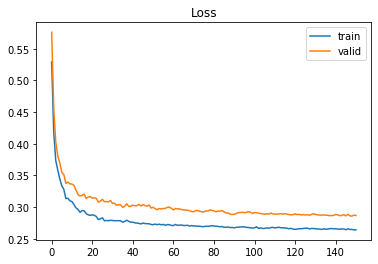

In [77]:
import matplotlib.pyplot as plt

# Loss curve
plt.plot(train_loss)
plt.plot(valid_loss)
plt.title('Loss')
plt.legend(['train', 'valid'])
plt.show()



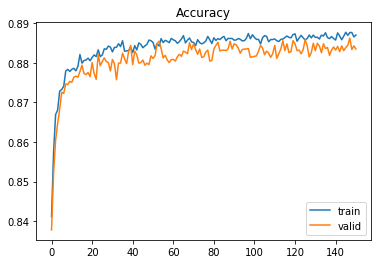

In [78]:
# Accuracy curve
plt.plot(train_acc)
plt.plot(valid_acc)
plt.title('Accuracy')
plt.legend(['train', 'valid'])
plt.savefig('acc.png')
plt.show()